In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np


data_root = '../../MyData/'

In [2]:
data = pd.read_csv("target_column.csv").drop('tic', axis=1)

In [31]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer()
scaler.fit(data)
scaled_np = scaler.transform(data)

scaled_tensor = torch.tensor(scaled_np)
print(scaled_tensor)
scaled_tensor.size()
# tensor = torch.tensor(data.drop("tic", axis=1).values, dtype=torch.float)

tensor([[0.0887, 0.1558, 0.7878,  ..., 0.7836, 0.6128, 0.3303],
        [0.8128,    nan, 0.7878,  ..., 0.4616, 0.5509, 0.0626],
        [0.3437, 0.0581, 0.3942,  ..., 0.5127, 0.1444,    nan],
        ...,
        [   nan,    nan, 0.9553,  ..., 0.3748, 0.3452, 0.7362],
        [0.8046, 0.8238, 0.1651,  ..., 0.1080, 0.1149, 0.9024],
        [0.8917, 0.9129, 0.0891,  ..., 0.4674, 0.4825, 0.7362]],
       dtype=torch.float64)


torch.Size([1197, 279])

In [32]:
from torch.utils.data import DataLoader, TensorDataset, random_split

scaled_tensor = scaled_tensor.unsqueeze(1)  # Now tensor has shape [n_samples, 1, sequence_length]


# Decide on the split ratio
train_ratio = 0.8
train_size = int(train_ratio * len(scaled_tensor))
test_size = len(scaled_tensor) - train_size

# Split the tensor
train_dataset, test_dataset = random_split(TensorDataset(scaled_tensor), [train_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [44]:
class Autoencoder1D(nn.Module):
    def __init__(self, hidden_dim):
        super(Autoencoder1D, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1),  # Output: [16, 140]
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),  # Output: [32, 70]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 70, hidden_dim)  # Compress to 2D for visualization
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 32 * 70),
            nn.ReLU(),
            nn.Unflatten(1, (32, 70)),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: [16, 140]
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=0),  # Changed output_padding to 0
            nn.Sigmoid()  # To ensure output is between 0 and 1
        )
    
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [6]:
# def nan_mse_loss(output, target, nan_mask):
#     # Mask NaN values
#     mask = ~nan_mask
#     # Compute squared error only for non-NaN values
#     squared_error = (output[mask] - target[mask]) ** 2
#     return squared_error.mean()


def custom_mse_loss(outputs, inputs, nan_mask):
    # Mask out NaNs
    masked_outputs = outputs[~nan_mask]
    masked_inputs = inputs[~nan_mask]
    
    return nn.MSELoss()(masked_outputs, masked_inputs)

In [45]:
# input_dim = 279
hidden_dim = 64  # Dimension of the compressed representation
autoencoder = Autoencoder1D(hidden_dim)

# Define loss function and optimizer
criterion = custom_mse_loss
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)


# Training loop
epochs = 50



for epoch in range(epochs):

    autoencoder.train()
    train_loss = 0
    for batch in train_loader:
        inputs = batch[0].float()  # Get the batch
        nan_mask = torch.isnan(inputs)
        inputs = torch.nan_to_num(inputs, nan=0.0)

        optimizer.zero_grad()
        outputs = autoencoder(inputs)  # Forward pass
        loss = criterion(outputs, inputs, nan_mask)  # Compute loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}')


    # Testing Phase
    autoencoder.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch[0].float()
            
            nan_mask = torch.isnan(inputs)
            inputs = torch.nan_to_num(inputs, nan=0.0)

            outputs = autoencoder(inputs)
            test_loss += criterion(outputs, inputs, nan_mask).item()

    avg_test_loss = test_loss / len(test_loader)
    print(f'Epoch {epoch+1}, Testing Loss: {avg_test_loss:.4f}\n')



Epoch 1, Training Loss: 0.0916
Epoch 1, Testing Loss: 0.0759

Epoch 2, Training Loss: 0.0664
Epoch 2, Testing Loss: 0.0607

Epoch 3, Training Loss: 0.0576
Epoch 3, Testing Loss: 0.0543

Epoch 4, Training Loss: 0.0514
Epoch 4, Testing Loss: 0.0486

Epoch 5, Training Loss: 0.0458
Epoch 5, Testing Loss: 0.0432

Epoch 6, Training Loss: 0.0403
Epoch 6, Testing Loss: 0.0387

Epoch 7, Training Loss: 0.0359
Epoch 7, Testing Loss: 0.0355

Epoch 8, Training Loss: 0.0327
Epoch 8, Testing Loss: 0.0330

Epoch 9, Training Loss: 0.0302
Epoch 9, Testing Loss: 0.0312

Epoch 10, Training Loss: 0.0281
Epoch 10, Testing Loss: 0.0296

Epoch 11, Training Loss: 0.0262
Epoch 11, Testing Loss: 0.0283

Epoch 12, Training Loss: 0.0246
Epoch 12, Testing Loss: 0.0279

Epoch 13, Training Loss: 0.0234
Epoch 13, Testing Loss: 0.0264

Epoch 14, Training Loss: 0.0220
Epoch 14, Testing Loss: 0.0254

Epoch 15, Training Loss: 0.0208
Epoch 15, Testing Loss: 0.0248

Epoch 16, Training Loss: 0.0197
Epoch 16, Testing Loss: 0.

In [46]:
autoencoder.eval()

# temp_point = scaled_tensor[3:8]
# print(temp_point.size())
# temp_mask = torch.isnan(temp_point)
# temp_point = torch.nan_to_num(temp_point, nan=0.0)
# print(temp_point.size())
# temp_point = temp_point.float()

# print(temp_point)
# temp_output = autoencoder(temp_point)
# print(temp_output)

# criterion(temp_output, temp_point, temp_mask)


with torch.no_grad():
    for batch in test_loader:
        temp_point = batch[0][5:10].float()
        
        temp_mask = torch.isnan(temp_point)
        temp_point = torch.nan_to_num(temp_point, nan=0.0)

        temp_output = autoencoder(temp_point)
        print(criterion(temp_output, temp_point, temp_mask))
        break

tensor(0.0122)


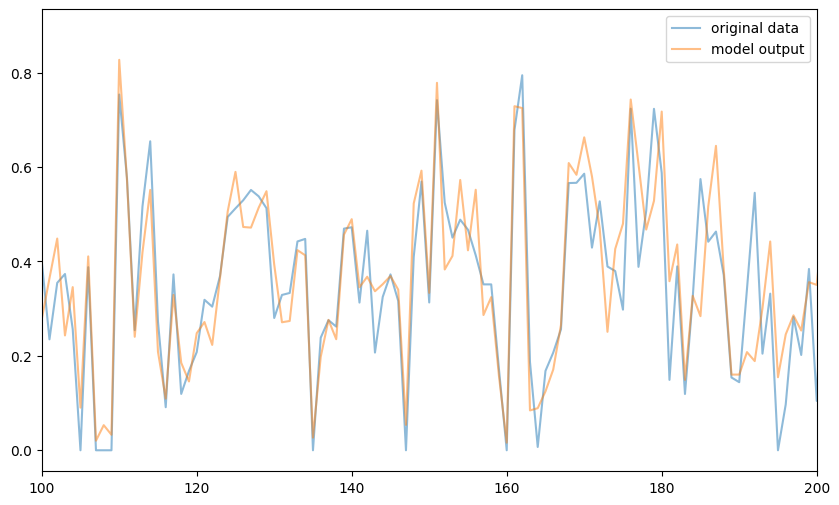

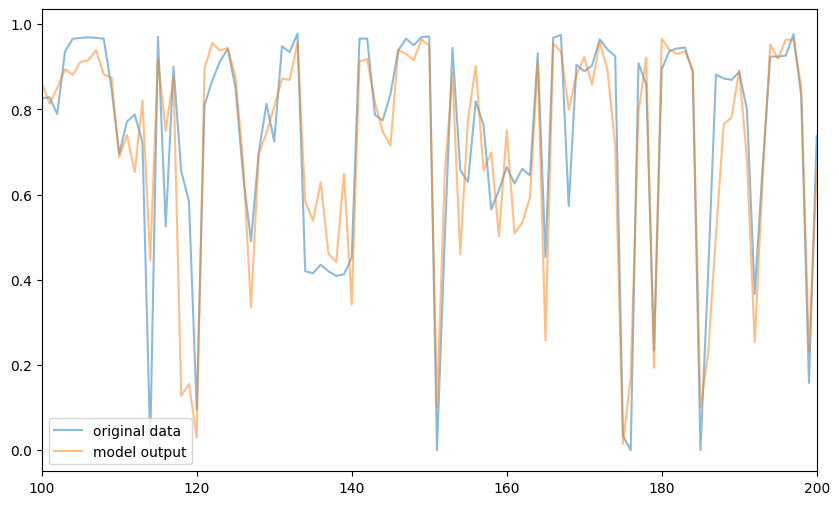

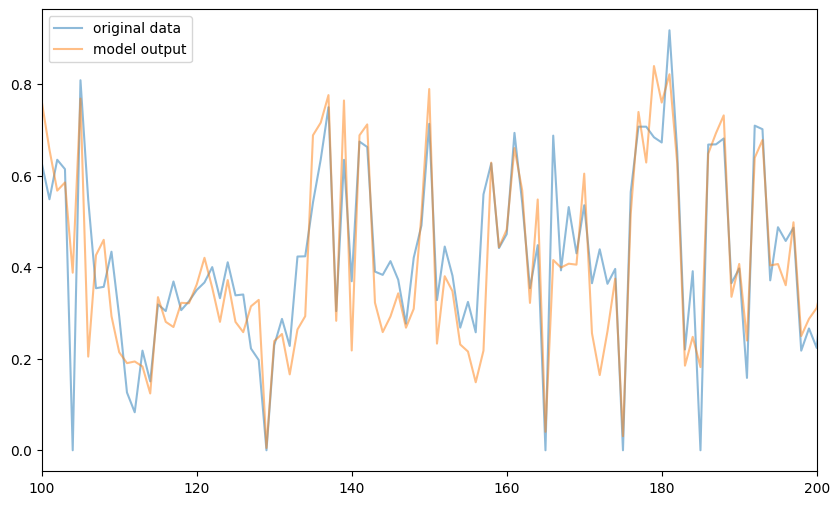

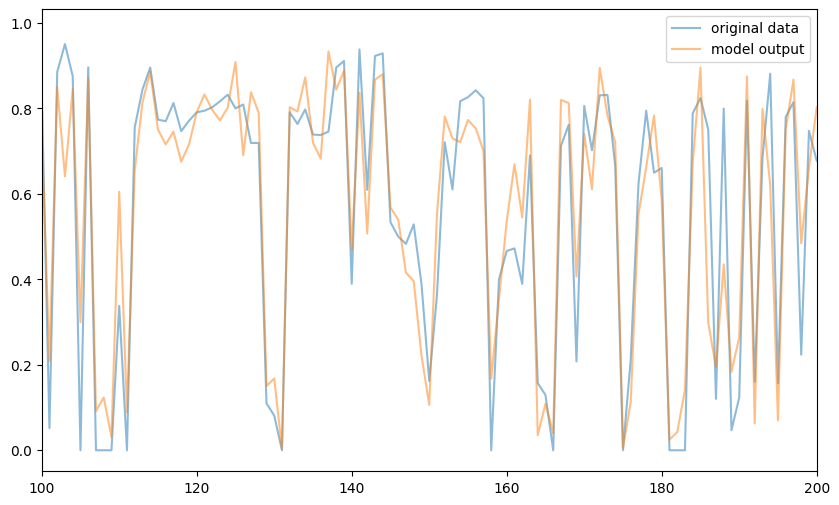

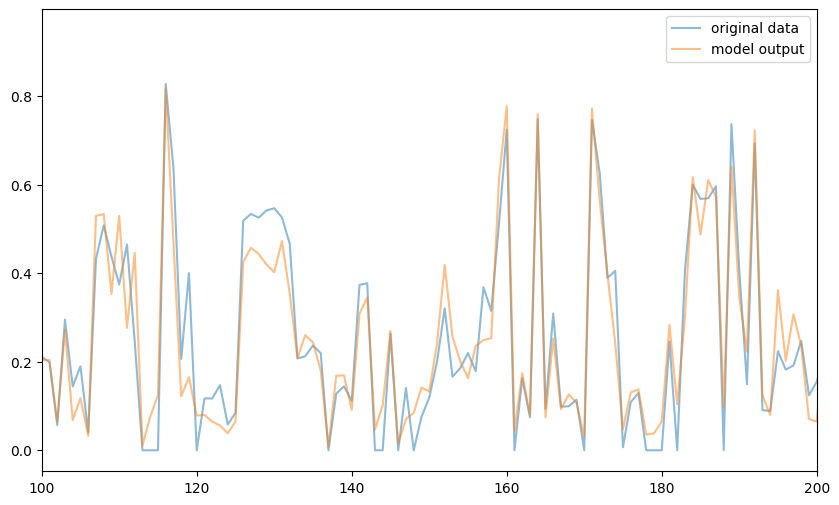

In [47]:
import matplotlib.pyplot as plt

# temp_point = temp_point[~temp_mask]
# temp_output = temp_output[~temp_mask]

for i in range(5):
    l1 = temp_point[i][~temp_mask[i]]
    l2 = temp_output[i].detach().numpy()[~temp_mask[i]]

    plt.figure(figsize=(10, 6))

    plt.plot(l1, alpha=0.5, label="original data")
    plt.plot(l2, alpha=0.5, label="model output")

    plt.xlim(100, 200)
    # plt.ylim(-0.05, 0.2)
    plt.legend()

    plt.show()